## Import packages and load data

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier

# import logistic regression libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

# import random forest libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# import cross validation libraries
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
# load data
df = pd.read_csv(r"C:\Users\woowe\Downloads\hospital_readmissions.csv")
print(df.head())

       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest change diabetes_med

## Data pre-processing

In [5]:
# check null values
missing_counts = df.isnull().sum()
print("Count of Missing Values")
print(missing_counts)

Count of Missing Values
age                  0
time_in_hospital     0
n_lab_procedures     0
n_procedures         0
n_medications        0
n_outpatient         0
n_inpatient          0
n_emergency          0
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
glucose_test         0
A1Ctest              0
change               0
diabetes_med         0
readmitted           0
dtype: int64


In [6]:
# check data types
df.dtypes

age                  object
time_in_hospital      int64
n_lab_procedures      int64
n_procedures          int64
n_medications         int64
n_outpatient          int64
n_inpatient           int64
n_emergency           int64
medical_specialty    object
diag_1               object
diag_2               object
diag_3               object
glucose_test         object
A1Ctest              object
change               object
diabetes_med         object
readmitted           object
dtype: object

In [7]:
# summary table of dataset
df.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


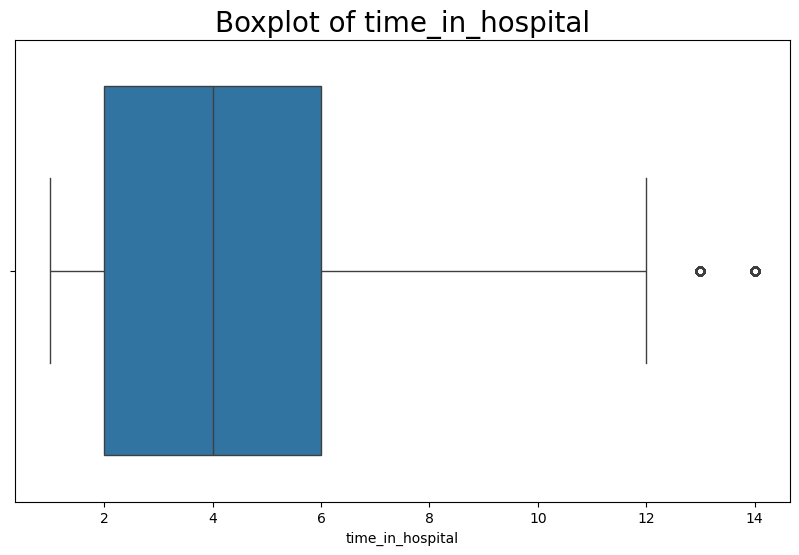

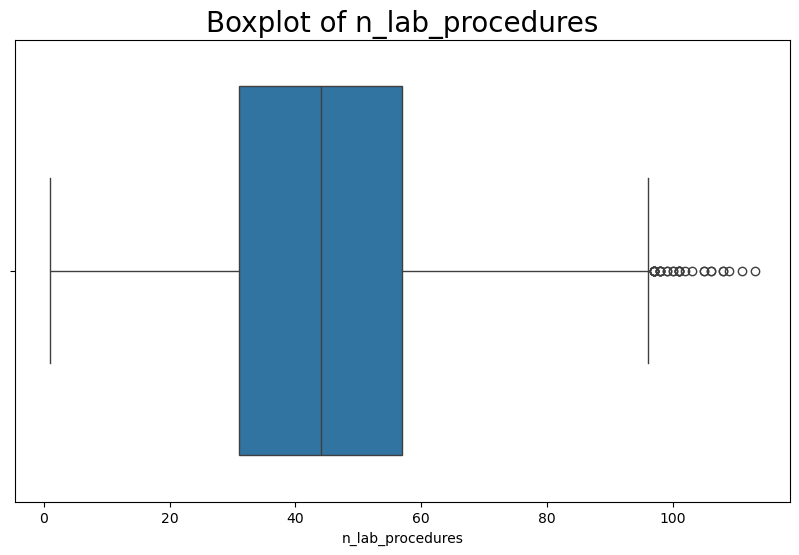

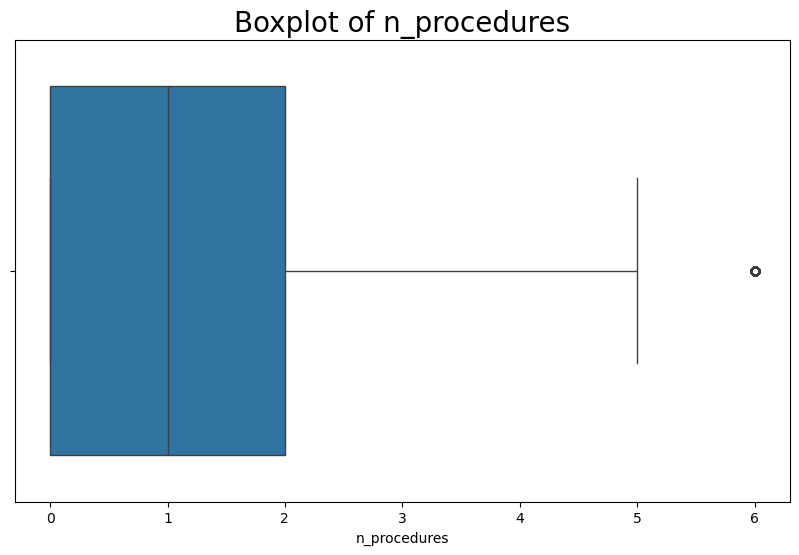

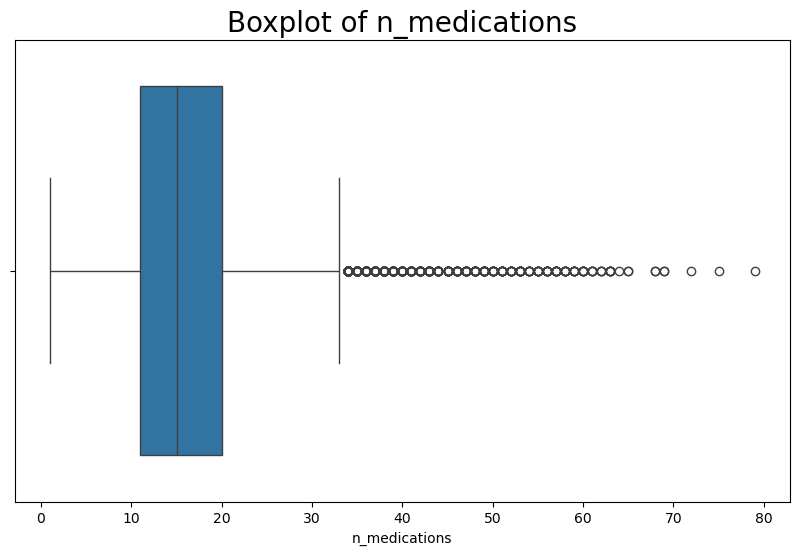

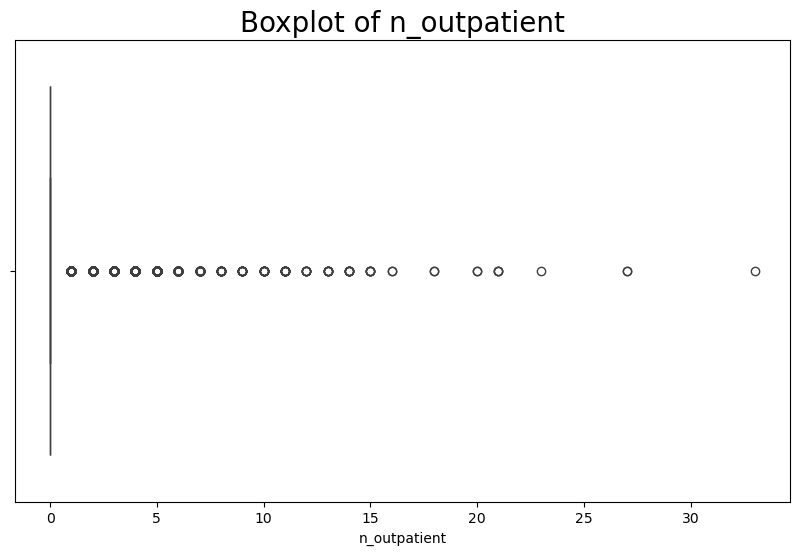

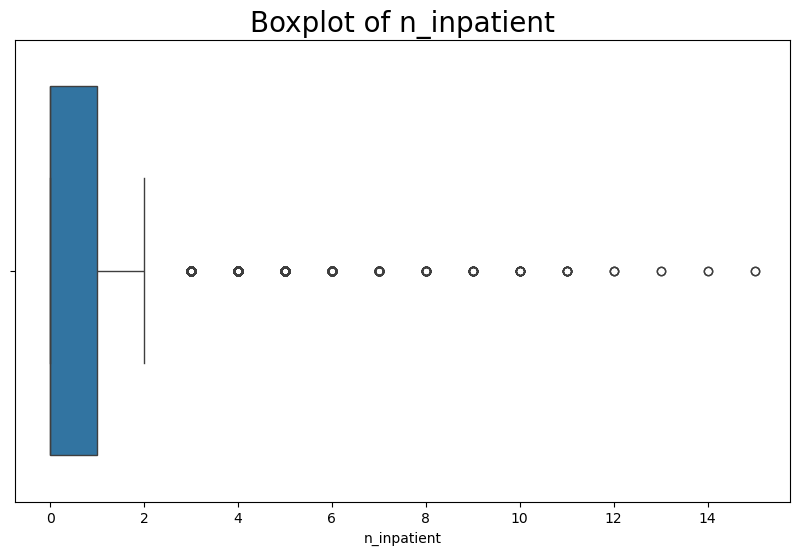

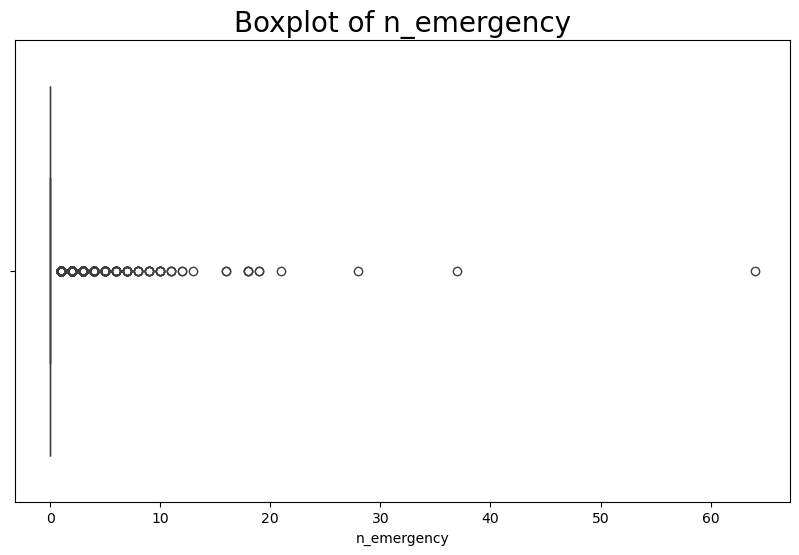

In [8]:
# check outliers
for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 6))  # Set figure size for each plot
    sns.boxplot(x=df[column])  # Create boxplot
    plt.title(f"Boxplot of {column}", fontdict={'fontsize': 20})  # Set title
    plt.xlabel(column)  # Label x-axis
    plt.show()  # Display the plot

In [9]:
# one-hotting independent variables
df2 = pd.get_dummies(df, columns = ['diabetes_med'], drop_first = True, dtype = int)
df3 = pd.get_dummies(df2, columns = ['age'], drop_first = True, dtype = int)
df4 = pd.get_dummies(df3, columns = ['medical_specialty'], drop_first = True, dtype = int)
df5 = pd.get_dummies(df4, columns = ['diag_1'], drop_first = True, dtype = int)
df6 = pd.get_dummies(df5, columns = ['diag_2'], drop_first = True, dtype = int)
df7 = pd.get_dummies(df6, columns = ['diag_3'], drop_first = True, dtype = int)
df8 = pd.get_dummies(df7, columns = ['glucose_test'], drop_first = True, dtype = int)
df9 = pd.get_dummies(df8, columns = ['A1Ctest'], drop_first = True, dtype = int)

# one-hotting change variable
df10 = pd.get_dummies(df9, columns = ['change'], drop_first = True, dtype = int)

# one-hot readmission variable
df11 = pd.get_dummies(df10, columns = ['readmitted'], drop_first = True, dtype = int)
print(df11.head())

   time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0                 8                72             1             18   
1                 3                34             2             13   
2                 5                45             0             18   
3                 2                36             0             12   
4                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency  diabetes_med_yes  age_[50-60)  \
0             2            0            0                 1            0   
1             0            0            0                 1            0   
2             0            0            0                 1            1   
3             1            0            0                 1            0   
4             0            0            0                 1            0   

   age_[60-70)  ...  diag_3_Missing  diag_3_Musculoskeletal  diag_3_Other  \
0            0  ...               0          

In [10]:
# define features (X) and target (y)
X = df11.drop(['readmitted_yes'], axis=1)
y = df11['readmitted_yes']

# split data points (rows) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Model  (with bagging and regularization)

In [12]:
# Initialize model
randomforest = RandomForestClassifier(max_depth = 6, random_state = 42, bootstrap=True)
bagging_rf = BaggingClassifier(estimator=randomforest, random_state=42)

# Define the hyperparameter grid for the BaggingClassifier
rf_param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__max_depth': [5, 10],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'n_estimators': [10, 20]
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(estimator=bagging_rf, param_grid=rf_param_grid, cv=5, scoring='roc_auc', verbose=4, return_train_score=True)

# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, n_estimators=10;, score=(train=0.669, test=0.645) total time=   3.0s
[CV 2/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, n_estimators=10;, score=(train=0.669, test=0.656) total time=   2.9s
[CV 3/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, n_estimators=10;, score=(train=0.669, test=0.652) total time=   3.0s
[CV 4/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, n_estimators=10;, score=(train=0.669, test=0.652) total time=   2.9s
[CV 5/5] END estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, n_estimators=10;, scor

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=RandomForestClassifier(max_depth=6,
                                                                          random_state=42),
                                         random_state=42),
             param_grid={'estimator__max_depth': [5, 10],
                         'estimator__min_samples_leaf': [1, 2],
                         'estimator__min_samples_split': [2, 5],
                         'estimator__n_estimators': [50, 100],
                         'n_estimators': [10, 20]},
             return_train_score=True, scoring='roc_auc', verbose=4)

In [13]:
# check the best parameters and the corresponding score
best_parameters_rf = grid_search_rf.best_params_
best_auc_score_rf = grid_search_rf.best_score_
print(f"Best Parameters (Random Forest): {best_parameters_rf}")
print(f"Best AUC Score (Random Forest): {best_auc_score_rf}")

Best Parameters (Random Forest): {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100, 'n_estimators': 20}
Best AUC Score (Random Forest): 0.6558415788910887


Test AUC (Random Forest): 0.609158244225415
Accuracy (Random Forest): 0.62
Confusion Matrix (Random Forest):
[[1991  667]
 [1243 1099]]


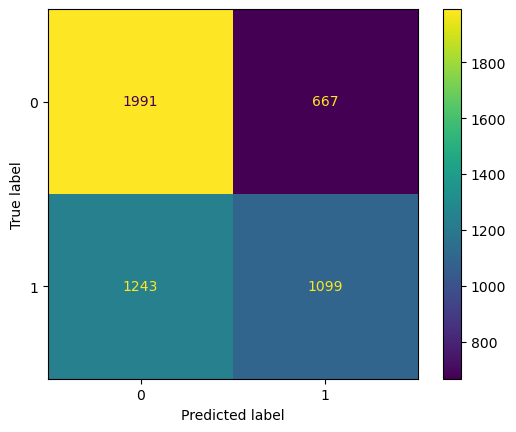

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2658
           1       0.62      0.47      0.54      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.61      5000



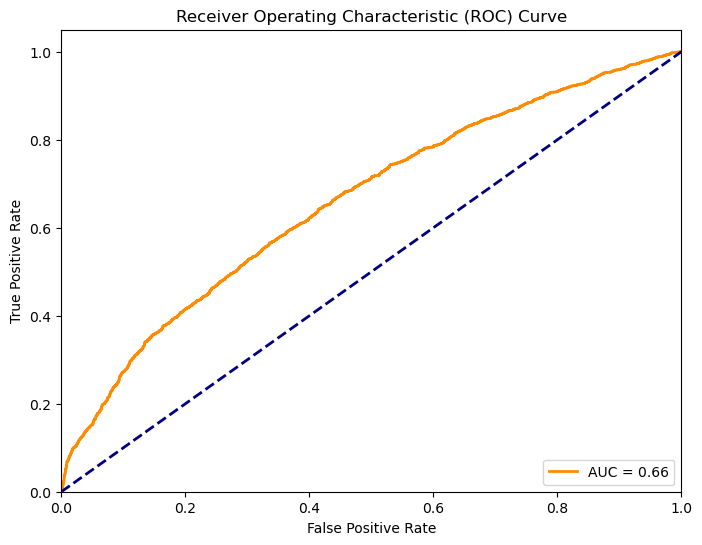

In [29]:
# evaluate on the test set
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test_scaled)
test_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"Test AUC (Random Forest): {test_auc_rf}")

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}')
print('Confusion Matrix (Random Forest):'); print(conf_matrix_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp.plot()
plt.show()
print('Classification Report:')
print(classification_rep_rf)

# plot roc curve and auc
y_prob_rf = grid_search_rf.predict_proba(X_test_scaled)[:, 1] # predict probabilities on the test set

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## XGBoost (With regularization)

In [60]:
# Initialize model
xgb_model = xgb.XGBClassifier(random_state = 42)

# Create the parameter grid: gbm_param_grid
xgb_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10],
    'alpha': [0, 0.1, 1], # Alpha/lasso regularisation
    'lambda': [0, 0.1, 1], # Lambda/ridge regularisation
    'learning_rate': [0.01, 0.05]    
}

# Perform grid search: grid_mse
grid_search_xgb = GridSearchCV(param_grid=xgb_param_grid, estimator=xgb_model, 
                        scoring='roc_auc', cv=5, verbose=4, return_train_score=True)

grid_search_xgb.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.650, test=0.638) total time=   0.1s
[CV 2/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.648, test=0.646) total time=   0.1s
[CV 3/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.646, test=0.643) total time=   0.2s
[CV 4/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.648, test=0.648) total time=   0.1s
[CV 5/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=50;, score=(train=0.650, test=0.639) total time=   0.1s
[CV 1/5] END alpha=0, colsample_bytree=0.3, lambda=0, learning_rate=0.01, max_depth=2, n_estimators=100;, score=(train=0.652, test=0.639) total time=   0.2s

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'alpha': [0, 0.1, 1], 'colsample_bytree': [0.3, 0.7],
                         'lambda': [0, 0.1, 1], 'learning_rate': [0.01, 0.05],
                         'max_depth': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=4)

In [61]:
# check the best parameters and the corresponding score
best_parameters_xgb = grid_search_xgb.best_params_
best_auc_score_xgb = grid_search_xgb.best_score_
print(f"Best Parameters (XGBoost): {best_parameters_xgb}")
print(f"Best AUC Score (XGBoost): {best_auc_score_xgb}")

Best Parameters (XGBoost): {'alpha': 1, 'colsample_bytree': 0.3, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best AUC Score (XGBoost): 0.656400017714472


Test AUC (XGBoost): 0.6118724453962996
Accuracy (XGBoost): 0.62
Confusion Matrix (XGBoost):
[[1985  673]
 [1225 1117]]


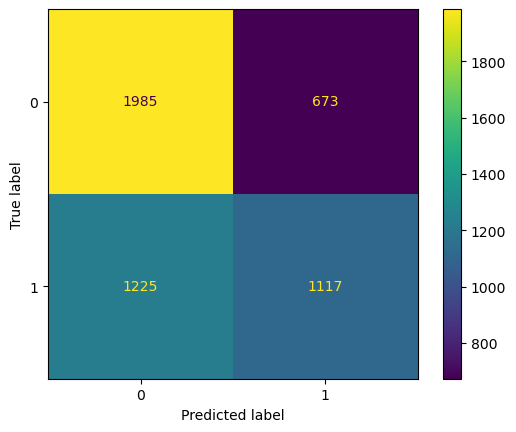

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68      2658
           1       0.62      0.48      0.54      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.61      5000



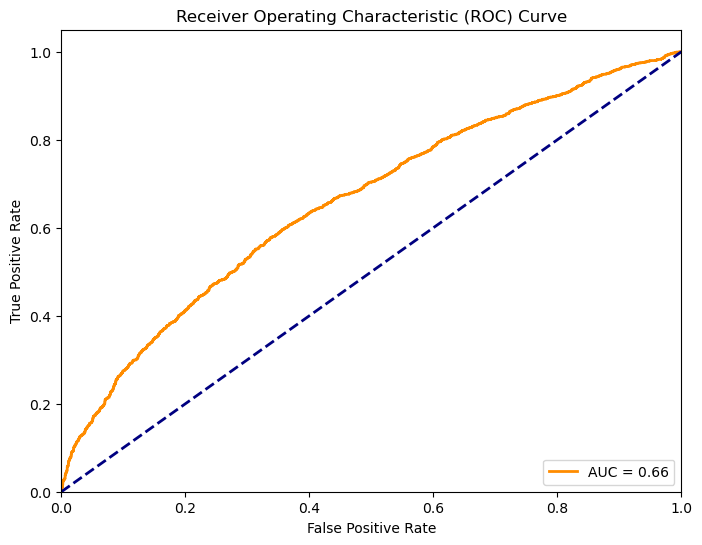

In [62]:
# evaluate on the test set
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_scaled)
test_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f"Test AUC (XGBoost): {test_auc_xgb}")

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb:.2f}')
print('Confusion Matrix (XGBoost):'); print(conf_matrix_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp.plot()
plt.show()
print('Classification Report:')
print(classification_rep_xgb)

# plot roc curve and auc
y_prob_xgb = grid_search_xgb.predict_proba(X_test_scaled)[:, 1] # predict probabilities on the test set

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'AUC = {roc_auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [63]:
# After fitting the model
importances_rf = best_model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices_rf[f]]} ({importances[indices_rf[f]]})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

Feature ranking:
1. feature n_inpatient (0.21924808621406555)
2. feature n_outpatient (0.05532350763678551)
3. feature n_emergency (0.05024033039808273)
4. feature diabetes_med_yes (0.03491698578000069)
5. feature diag_1_Diabetes (0.024121876806020737)
6. feature age_[80-90) (0.024047480896115303)
7. feature n_medications (0.02300611324608326)
8. feature age_[50-60) (0.022845910862088203)
9. feature n_lab_procedures (0.02185099758207798)
10. feature diag_3_Missing (0.020959872752428055)
11. feature n_procedures (0.020453358069062233)
12. feature glucose_test_no (0.0202623400837183)
13. feature age_[90-100) (0.020105483010411263)
14. feature medical_specialty_Other (0.01993732713162899)
15. feature time_in_hospital (0.019126061350107193)
16. feature diag_1_Other (0.01873692125082016)
17. feature medical_specialty_Emergency/Trauma (0.018381884321570396)
18. feature A1Ctest_normal (0.017974916845560074)
19. feature age_[70-80) (0.01761596091091633)
20. feature change_yes (0.01709990948438

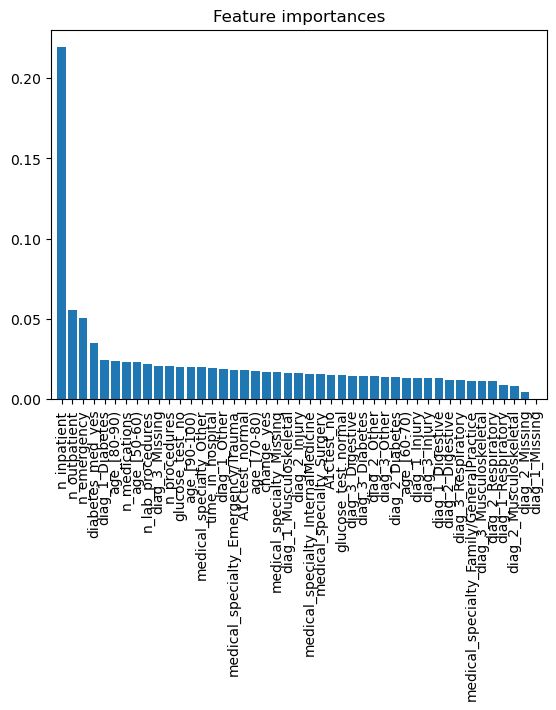

In [70]:
# After fitting the model
importances_xgb = best_model_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices_xgb[f]]} ({importances_xgb[indices_xgb[f]]})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_xgb[indices_xgb], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_xgb], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()